In [2]:
#importing numpy and pandas libraries for data operations and data loading
import numpy as np 
import pandas as pd 
#importing nltk and tensorflow preprosessing libraries for data processing and feature engineering
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#importing keras and tensorflow libraries for word embeddings and model building
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dense, Bidirectional,Input
from tensorflow.keras.layers import Dropout, SpatialDropout1D, TimeDistributed,Flatten, GlobalMaxPool1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import multiply
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, utils, callbacks, optimizers, regularizers
import re
#importing libraries for splitting the data and for tracking the progress
from tqdm import tqdm
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [2]:
#installing numpy 1.19.5 to balance with tensorflow
pip install numpy==1.19.5

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Reading the training data from train.csv
train_df=pd.read_csv('train.csv')


In [4]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
#Reading the test data from test.csv
test_df=pd.read_csv('test.csv')

/Library/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:

test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [7]:
#drop unnecessary columns like id,qid1,qid2 from train data
train_df = train_df.drop(['id','qid1','qid2'],axis=1)
#drop unnecessary columns like test_id from test data
test_df = test_df.drop(['test_id'],axis=1)
train_df.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [8]:
#checking for the balance of train data with is_duplicate variable 
train_df[train_df['is_duplicate']==1].shape,train_df[train_df['is_duplicate']==0].shape

((149263, 3), (255027, 3))

In [9]:
#Considering full amount of is_duplicate=1 data as it is small than is_duplicate=0
is_duplicate = train_df[train_df['is_duplicate']==1]
#considering 149260 rows of is_duplicate =0 data to maintain the balance of train data
not_duplicate = train_df[train_df['is_duplicate']==0].sample(149260)



In [10]:
#concating the is_duplicate and not_duplicate to form training data 
train_df = pd.concat([is_duplicate,not_duplicate])
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df

,question1,question2,is_duplicate
0,I get distracted and lose concentration easily...,I am not able to concentrate and get distracte...,1
1,"What are some Interesting, unknown Facts about...",What are some of the little known facts about ...,1
2,Why were credits moved from the beginning of a...,When did movie credits shift to the end of the...,1
3,Why do people ask questions on Quora that can ...,Why do so many people ask questions on Quora.c...,1
4,"Why was ""The Big Comfy Couch"" canceled?",Why was The Secret Circle canceled?,0
...,...,...,...
298518,I am in love with a codependent who has gone b...,I am in a relationship with my manager who is ...,0
298519,Why do I feel lack of energy after masturbation?,Why do I feel so weak after masturbation?,1
298520,Why doesn't an iPhone get any viruses?,How do iPhones get viruses? How can we avoid t...,1
298521,Why Indian football team never qualified in Ol...,Why did Joginder Sharma not make it to the Ind...,0


In [11]:
# Defining a POS function to categorize the text to a particular parts of speech
def pos(tag):
    if tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    elif tag.startswith('J'):
        return wordnet.ADJ
    else:
        return wordnet.NOUN

lemmatizer = WordNetLemmatizer()#Used Wordnet Lemmatizer to group different inflicted forms of a word together.

In [12]:
# Stacking up all the stopwords in english language 
STOPWORDS = set(stopwords.words('english'))

# Defining a clean text method
def clean_text(text):
    text = text.lower() #Converting the text to lower case.
    text = re.compile(r'<[^>]+>').sub(' ', text) #Replacing HTML tags with blank space
    text = re.compile(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+').sub('', text)#URLS
    text = re.compile(r'#(\w+)').sub('', text)#Replacing Hash tags  with blank space
    text = re.compile(r'@(\w+)').sub('', text)#Replacing @ tags with blank space
    text = re.compile(r"[^a-z0-9\-]").sub(' ', text)#Replacing unwanted words with blank space 
    
    
    
    for word in text.split():
        if word not in STOPWORDS and len(word)>3:
            text = " ".join(lemmatizer.lemmatize(word.strip(), pos(pos_tag([word.strip()])[0][1])))
            #filters and return the text after removing stopwords, lemmatization and pos tags
    
    return text

In [13]:
#Droping out null values
train_df = train_df.dropna()

In [14]:
# applyiing the clean_text function to question1 in train data
train_df['q1'] = train_df['question1'].apply(clean_text)


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
import nltk

In [ ]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [15]:
#Droping out null values
test_df = test_df.dropna()

In [16]:
# applyiing the clean_text function to question2 in train data 
train_df['q2'] = train_df['question2'].apply(clean_text)

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
train_df['q1']

0         distract lose concentration easily back track ...
1                     interest unknown fact partition india
2                             credit move begin movie movie
3                people question quora easily answer google
4                                        comfy couch cancel
                                ...                        
298518    love codependent go back narcissistic ex-wife ...
298519                        feel lack energy masturbation
298520                                         iphone virus
298521    indian football team never qualify olympics we...
298522    virat kohli really well batsman sachin tendulk...
Name: q1, Length: 298521, dtype: object

In [18]:
#calling Tokenizer 
tokenizer = Tokenizer(num_words = 200000)
#Updates internal vocabulary based on list of texts
tokenizer.fit_on_texts(list(train_df['q1'].values.astype(str))+list(train_df['q2'].values.astype(str)))

#Transforms each text in question1 texts in training data to a sequence of integers and pads each sequence to attain a max_len of 30
X_train_q1 = tokenizer.texts_to_sequences(train_df['q1'].values.astype(str))
X_train_q1 = pad_sequences(X_train_q1, maxlen = 30, padding = 'post')
#Transforms each text in question2 texts in training data to a sequence of integers and pads each sequence to attain a max_len of 30
X_train_q2 = tokenizer.texts_to_sequences(train_df['q2'].values.astype(str))
X_train_q2 = pad_sequences(X_train_q2, maxlen = 30, padding = 'post')

In [19]:
# applyiing the clean_text function to question1 in test data 
test_df['q1'] = test_df['question1'].apply(clean_text)
# applyiing the clean_text function to question2 in test data 
test_df['q2'] = test_df['question2'].apply(clean_text)
test_df.head()

,question1,question2,q1,q2
0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,surface compare ipad,microsoft choose core core home surface
1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,hair transplant much would cost,much cost hair transplant require
2,What but is the best way to send money from Ch...,What you send money to China?,best send money china,send money china
3,Which food not emulsifiers?,What foods fibre?,food emulsifier,food fibre
4,"How ""aberystwyth"" start reading?",How their can I start reading?,aberystwyth start reading,start reading


In [20]:
#Transforms each text in question1 texts in test data to a sequence of integers and pads each sequence to attain a max_len of 30
X_test_q1 = tokenizer.texts_to_sequences(test_df['q1'].ravel())
X_test_q1 = pad_sequences(X_test_q1,maxlen = 30, padding='post')
#Transforms each text in question2 texts in test data to a sequence of integers and pads each sequence to attain a max_len of 30
X_test_q2 = tokenizer.texts_to_sequences(test_df['q2'].astype(str).ravel())
X_test_q2 = pad_sequences(X_test_q2, maxlen = 30, padding='post')

In [21]:
e_index = {}
#Loading glove file with 200 dimesions
glovefile = open('glove.6B.200d.txt','r',encoding='utf-8')
for line in tqdm(glovefile):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
# finding number of word vectors
    e_index[word] = coefs
glovefile.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:16, 23704.51it/s]

Found 400000 word vectors.


In [22]:
#Initializing  embedding matrix 
e_matrix = np.zeros((len(tokenizer.word_index)+1, 200))
#Creating embedding matrix
for words, index in tqdm(tokenizer.word_index.items()):
    #loading word vectors into embedding vector 
    e_vector = e_index.get(word)
    if e_vector is not None:
        e_matrix[index] = e_vector

100%|█████████████████████████████████| 55298/55298 [00:00<00:00, 571762.55it/s]


In [23]:
y = train_df['is_duplicate']

In [24]:
#splitting the data
X_train_q1,X_valid_q1, X_train_q2, X_valid_q2, y_train, y_valid = train_test_split(X_train_q1, X_train_q2, y, test_size=0.20, random_state=12)
print(X_train_q1.shape, X_train_q2.shape, y_train.shape)
print(X_valid_q1.shape, X_valid_q2.shape, y_valid.shape)

(238816, 30) (238816, 30) (238816,)
(59705, 30) (59705, 30) (59705,)


In [25]:
#converting data to numpy array
X_train_q1 = np.array(X_train_q1)
X_train_q2 = np.array(X_train_q2)
X_valid_q1 = np.array(X_valid_q1)
X_valid_q2 = np.array(X_valid_q2)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

In [26]:
vocab_size = len(tokenizer.word_index) + 1

In [63]:
pip install numpy==1.19.5

Note: you may need to restart the kernel to use updated packages.


In [27]:
#defining training and testing and validation data
X_train = [X_train_q1,X_train_q2]
X_val = [X_valid_q1,X_valid_q2]
X_test = [X_test_q1,X_test_q2]

In [28]:
#defining input shape to feed into embedding layer
input_q1 = Input(shape = X_train[0].shape[1])
input_q2 = Input(shape = X_train[0].shape[1])

In [29]:
word_index = tokenizer.word_index
nb_words = len(word_index)+1
DIM=200

In [30]:
#creating the embedding layer 
embedding_layer = Embedding(nb_words,
                            DIM,
                            input_length = X_train[0].shape[1],
                            weights = [e_matrix],
                            trainable=False)
# Embedded sequences of input_q1 and input_q2
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)
# Defining the biderctional LSTM layer
bilstm_layer = Bidirectional(LSTM(64, return_sequences=False))
# Defining the BiLSTM layers for embedded sequence1 and embedded sequence2
x1 = bilstm_layer(embedded_sequences_q1)
x2 = bilstm_layer(embedded_sequences_q2)
# Calculating the distance betwwen the question vecyors
distance = layers.Concatenate()([x1, x2])

x = Dense(64, activation="relu")(distance)
preds = Dense(1, activation="sigmoid")(x)
# Defining and building the final model
model = Model(inputs=[input_q1, input_q2], outputs=preds)
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])



model.summary()



2022-04-17 16:59:06.492155: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-17 16:59:06.494500: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 200)      11059800    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 128)          135680      embedding[0][0]              

In [41]:
# Training the model

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_valid),
    batch_size=2000, 
    epochs=10,
    
)


Train on 238816 samples, validate on 59705 samples
Epoch 1/10
238816/238816 [==============================] - 363s 2ms/sample - loss: 0.6538 - accuracy: 0.6027 - val_loss: 0.6529 - val_accuracy: 0.6045
Epoch 2/10
238816/238816 [==============================] - 386s 2ms/sample - loss: 0.6539 - accuracy: 0.6026 - val_loss: 0.6526 - val_accuracy: 0.6045
Epoch 3/10
238816/238816 [==============================] - 404s 2ms/sample - loss: 0.6539 - accuracy: 0.6029 - val_loss: 0.6529 - val_accuracy: 0.6050
Epoch 4/10
238816/238816 [==============================] - 374s 2ms/sample - loss: 0.6538 - accuracy: 0.6027 - val_loss: 0.6525 - val_accuracy: 0.6050
Epoch 5/10
238816/238816 [==============================] - 446s 2ms/sample - loss: 0.6538 - accuracy: 0.6025 - val_loss: 0.6526 - val_accuracy: 0.6045
Epoch 6/10
238816/238816 [==============================] - 468s 2ms/sample - loss: 0.6537 - accuracy: 0.6024 - val_loss: 0.6527 - val_accuracy: 0.6045
Epoch 7/10
238816/238816 [===========

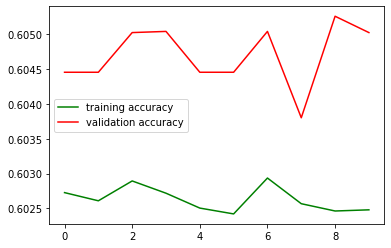

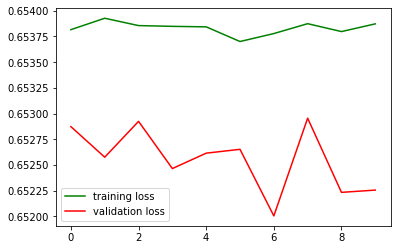

[0.60272765, 0.60261035, 0.60289514, 0.60271925, 0.6025057, 0.60242194, 0.602937, 0.6025685, 0.60246384, 0.6024806]


In [43]:
# obtaining  the  accuracy and loss for training 
accuracy = history.history["accuracy"]
loss = history.history["loss"]
# obtaining  the  accuracy and loss for validation
val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

#plotting the accuracy for training and validation
plt.plot(accuracy,'g',label='training accuracy')
plt.plot(val_accuracy, 'r', label='validation accuracy')
plt.legend()
plt.show()

#plotting the loss for training and validation
plt.plot(loss,'g',label='training loss')
plt.plot(val_loss, 'r', label='validation loss')
plt.legend()
plt.show()

In [50]:
model.save('modelmals.h5')